# Set Up

In [1]:
import os
import time
from dataclasses import dataclass
from functools import reduce
from operator import mul
from typing import Any, Optional, Union
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import wandb
import toy_model_tests

MAIN = __name__ == "__main__"
IS_CI = os.getenv("IS_CI")

# Introduction

We are going to re-implementing the [2020 paper **Denoising Diffusion Probabilistic Models**](https://arxiv.org/pdf/2006.11239.pdf) by implementing and training a tiny diffusion model from scratch using the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This paper was an influential early paper in the field of realistic image generation.

[FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of 60k training examples and 10k test examples that belong to classes such as "t-shirt" or "sandal". Each image is 28x28 pixels and in 8-bit grayscale. We think of those dataset examples as being samples drawn IID from some larger input distribution "the set of all FashionMNIST images".

One way to think about the input distribution is a mapping from each of the $256^{28*28}$ grayscale images to the probability that the image would be collected if we collected more training examples via an identical process as was used to obtain the 60K training examples.

Our goal in generative modeling is to take this input distribution and learn a very rough estimate of the probability in various regions. It should be near zero for images that look like random noise, and also near zero for a picture of a truck since that isn't part of the concept of "the set of all FashionMNIST images".

For our training examples, the fact that they were already sampled is evidence that their probability should be pretty high, but we only have information on 60K examples which is really not a lot compared to the $256^{28*28}$ total possible grayscale images. To have any hope of mapping out this space, we need to make some assumptions.

The assumption behind the forward process is that if we add Gaussian noise to an image from the distribution, on average this makes the noised image less likely to belong to the distribution. (This isn't guaranteed - there exists some random noise that you could sample with positive probability that is exactly what's needed to turn your sandal into a stylish t-shirt.)

The claim is that this is an empirical fact about the way the human visual system perceives objects - a sandal with a small splotch on it still looks like a sandal to us. As long as this holds most of the time, then we've successfully generated an additional training example. In addition, we know something about how the new example relates to the original example.

<details>
<summary>Note that this is similar but not the same as data augmentation in traditional supervised learning.</summary>

 In that setup, we make a perturbation to the original image and claim that the class label is preserved - that is, we would tell the model via the loss function that our noised sandal is exactly as much a sandal as the original sandal is, for any level of noise up to some arbitrary maximum. In today's setup, we're claiming that the noised sandal is less of a FashionMNIST member in proportion to the amount of noise involved.
 
</details>

Now that we know how to generate as much low-probability data as we want, in theory we could learn a reverse function that takes an image and returns one that is *more* likely to belong to the distribution.

Then we could just repeatedly apply the reverse function to "hill climb" and end up with a final image that has a relatively large probability. We know that deep neural networks are a good way to learn complicated functions, if you can define a loss function suitable for gradient descent and if you can find a suitable parameterization so that learning is smooth.


## Creating dataset

We'll first generate a toy dataset of random color gradients, and train the model to be able to recover them. This should be an easy task because the structure in the data is simple.

In [2]:
def gradient_images(n_images: int, img_size: tuple[int, int, int]) -> t.Tensor:
    """
    Generate n_images of img_size, each being a color gradient.
    
    Args:
        n_images: Number of gradient images to generate
        img_size: Tuple of (channels, height, width)
    
    Returns:
        Tensor of shape (n_images, channels, height, width) containing normalized gradients
    """
    C, H, W = img_size
    
    # Keep corners as integers (0-255) like the original
    corners = t.randint(0, 255, (2, n_images, C), dtype=t.float32)
    
    # Create coordinate grids
    x_coords = t.linspace(0, W / (W + H), W)
    y_coords = t.linspace(0, H / (W + H), H)
    x, y = t.meshgrid(x_coords, y_coords, indexing="xy")
    
    # Use grid[-1, -1] for normalization exactly as original
    grid = x + y
    grid = grid / grid[-1, -1]
    
    # Expand dimensions for broadcasting
    grid = grid.unsqueeze(0).unsqueeze(0)  # shape: 1, 1, H, W
    grid = grid.expand(n_images, C, H, W)   # shape: n_images, C, H, W
    
    # Calculate gradients using broadcasting but keeping original value ranges
    start_colors = corners[0].unsqueeze(-1).unsqueeze(-1)  # shape: n_images, C, 1, 1
    color_ranges = (corners[1] - corners[0]).unsqueeze(-1).unsqueeze(-1)
    
    # Combine everything and normalize at the end like original
    gradients = start_colors + grid * color_ranges
    gradients = gradients / 255
    
    assert gradients.shape == (n_images, C, H, W)
    
    return gradients


def plot_images(imgs: t.Tensor, titles: Optional[list[str]] = None) -> None:
    if IS_CI:
        return
    n_images = imgs.shape[0]
    fig, axes = plt.subplots(1, n_images, figsize=(3*n_images, 3))
    
    for i in range(n_images):
        img = rearrange(imgs[i], "c h w -> h w c")
        axes[i].imshow(img.numpy())
        if titles and i < len(titles):
            axes[i].set_title(titles[i])
        axes[i].axis('off')  # This removes the axes for cleaner visualization
    
    plt.tight_layout()  # Adjusts spacing between subplots
    plt.show()

In [3]:
def plot_img(img: t.Tensor, title: Optional[str] = None) -> None:
    if IS_CI:
        return
    img = rearrange(img, "c h w -> h w c")
    plt.imshow(img.numpy())
    if title:
        plt.title(title)
    plt.show()

A few samples from the input distribution: 


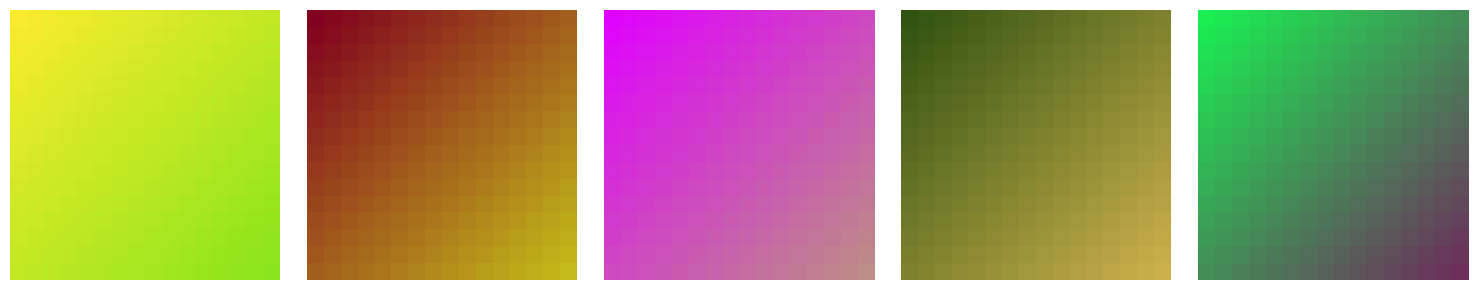

In [4]:
print("A few samples from the input distribution: ")
img_shape = (3, 16, 16)
n_images = 5
imgs = gradient_images(n_images, img_shape)
plot_images(imgs) # Try running a few times until you understand color gradients

In [5]:
def normalize_img(img: t.Tensor) -> t.Tensor:
    return img * 2 - 1


def denormalize_img(img: t.Tensor) -> t.Tensor:
    return ((img + 1) / 2).clamp(0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.6392157].


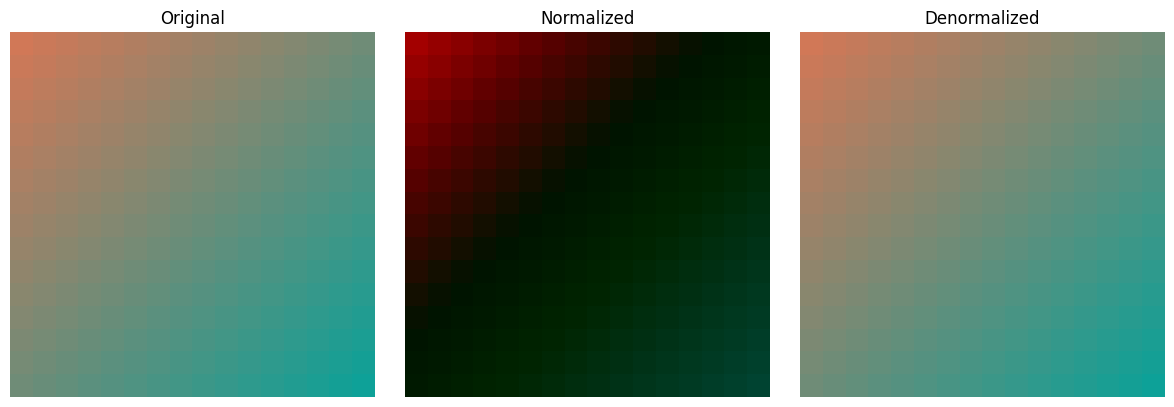

In [6]:
def plot_image_comparison(img, titles=["Original", "Normalized", "Denormalized"]):
    if IS_CI:
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Create the three versions of the image
    images = [
        img,
        normalize_img(img),
        denormalize_img(normalize_img(img))
    ]
    
    for i, (ax, image, title) in enumerate(zip(axes, images, titles)):
        img_show = rearrange(image, "c h w -> h w c")
        ax.imshow(img_show.numpy())
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage:
plot_image_comparison(gradient_images(n_images, img_shape)[0])

In [7]:
def linear_schedule(max_steps: int, min_noise: float = 0.0001, max_noise: float = 0.02) -> t.Tensor:
    """Return the forward process variances as in the paper.

    max_steps: total number of steps of noise addition
    out: shape (step=max_steps, ) the amount of noise at each step
    """
    return t.linspace(min_noise, max_noise, max_steps)

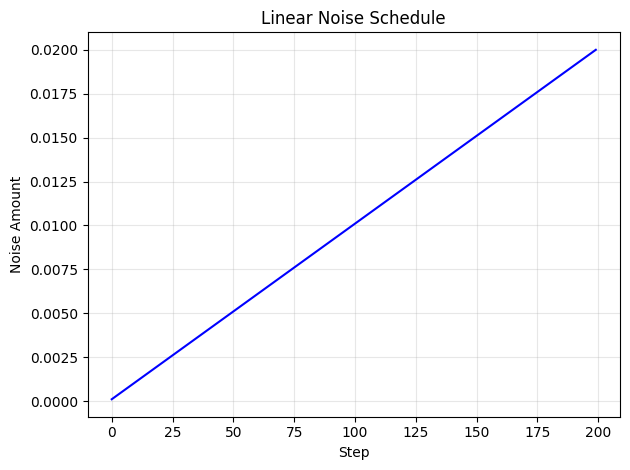

toy_model_tests.test_linear_schedule passed in 0.00s.


In [8]:
steps = 200
betas = linear_schedule(steps)


plt.figure()
plt.plot(range(steps), betas, 'b-', label='Noise Schedule')
plt.title('Linear Noise Schedule')
plt.xlabel('Step')
plt.ylabel('Noise Amount')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

toy_model_tests.test_linear_schedule(linear_schedule)

In [9]:
def q_eq2(x: t.Tensor, num_steps: int, betas: t.Tensor) -> t.Tensor:
    """
    Add noise to the input image iteratively using a noise schedule.

    Args:
        x: Input image tensor of shape (channels, height, width)
        num_steps: Number of noise iterations to perform
        betas: Noise schedule tensor of shape (T,) containing variance values,
              where T >= num_steps

    Returns:
        Noised image tensor of shape (channels, height, width)
    """
    for beta in betas[:num_steps]:
        x = t.normal(t.sqrt(1 - beta) * x, t.sqrt(beta))
        # OR
        # x = t.sqrt(1 - beta) * x + t.randn_like(x) * t.sqrt(beta)
    return x

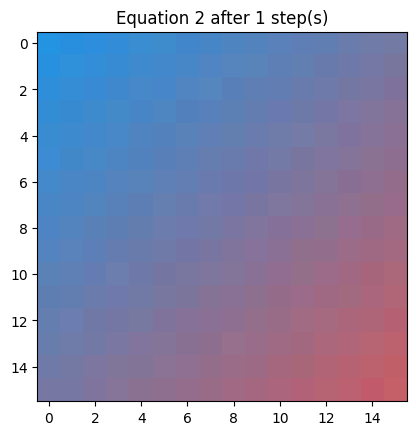

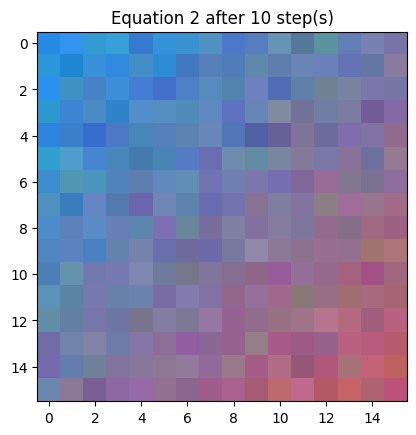

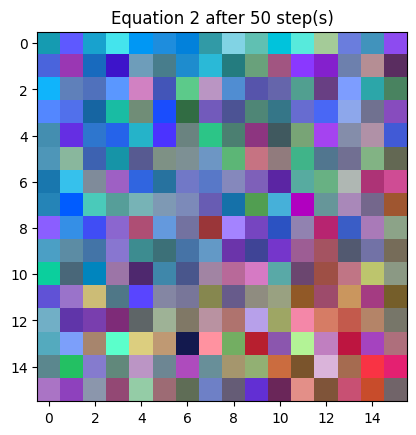

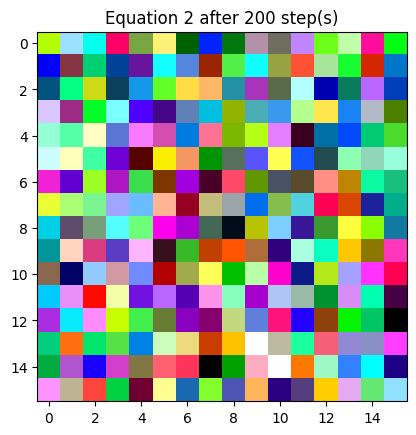

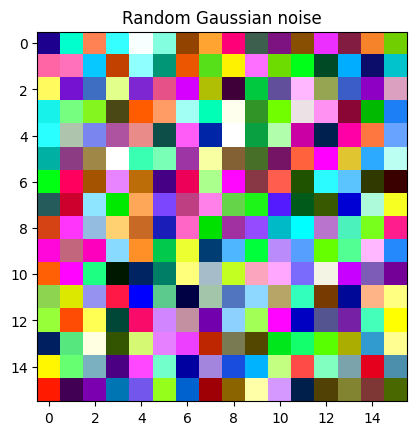

toy_model_tests.test_q_eq2 passed in 0.31s.


In [10]:
x = normalize_img(gradient_images(1, (3, 16, 16))[0])
for n in [1, 10, 50, 200]:
    xt = q_eq2(x, n, betas)
    plot_img(denormalize_img(xt), f"Equation 2 after {n} step(s)")
plot_img(denormalize_img(t.randn_like(xt)), "Random Gaussian noise")
toy_model_tests.test_q_eq2(q_eq2, linear_schedule, x)


In [11]:
def q_eq4(x: t.Tensor, num_steps: int, betas: t.Tensor) -> t.Tensor:
    """Equivalent to Equation 2 but without a for loop."""
    alphas = 1.0 - betas
    alpha_bar = t.prod(alphas[:num_steps])
    noise = t.randn_like(x)
    return t.sqrt(alpha_bar) * x + t.sqrt(1 - alpha_bar) * noise

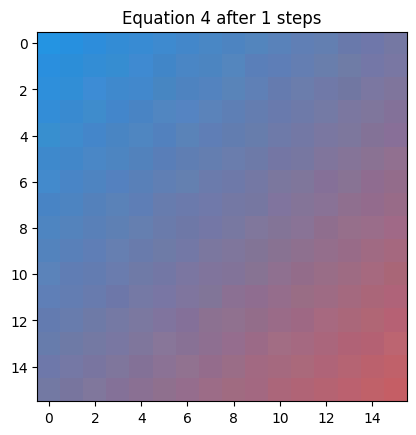

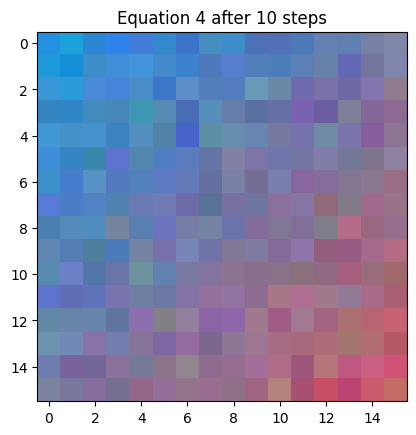

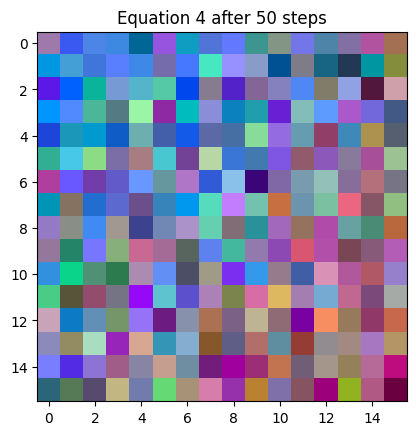

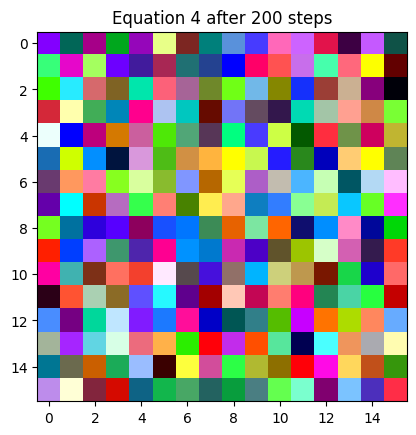

toy_model_tests.test_q_eq4 passed in 0.00s.


In [12]:
for n in [1, 10, 50, 200]:
    xt = q_eq4(x, n, betas)  # type: ignore
    plot_img(denormalize_img(xt), f"Equation 4 after {n} steps")
toy_model_tests.test_q_eq4(q_eq4, linear_schedule, x)

In [13]:
class NoiseSchedule(nn.Module):
    betas: t.Tensor
    alphas: t.Tensor
    alpha_bars: t.Tensor

    def __init__(
        self, max_steps: int, device: Union[t.device, str], min_noise: float = 0.0001, max_noise: float = 0.02
    ) -> None:
        super().__init__()
        self.max_steps = max_steps
        self.device = device
        self.register_buffer("betas", linear_schedule(max_steps, min_noise, max_noise))
        alphas = 1 - self.betas
        self.register_buffer("alphas", alphas)
        alpha_bars = t.cumprod(alphas, dim=-1)
        self.register_buffer("alpha_bars", alpha_bars)
        self.to(device)

    @t.inference_mode()
    def beta(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the beta(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.betas[num_steps]

    @t.inference_mode()
    def alpha(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the alphas(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.alphas[num_steps]

    @t.inference_mode()
    def alpha_bar(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        """
        Returns the alpha_bar(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        """
        return self.alpha_bars[num_steps]

    def __len__(self) -> int:
        return self.max_steps

In [14]:
def noise_img(
    img: t.Tensor, noise_schedule: NoiseSchedule, max_steps: Optional[int] = None
) -> tuple[t.Tensor, t.Tensor, t.Tensor]:
    """
    Adds a random number of steps of noise to each image in img.

    img: An image tensor of shape (B, C, H, W)
    noise_schedule: The NoiseSchedule to follow
    max_steps: if provided, only perform the first max_steps of the schedule

    Returns a tuple composed of:
    num_steps: an int tensor of shape (B,) of the number of steps of noise added to each image
    noise: the unscaled, standard Gaussian noise added to each image, a tensor of shape (B, C, H, W)
    noised: the final noised image, a tensor of shape (B, C, H, W)
    """
    (B, C, H, W) = img.shape
    if max_steps is None:
        max_steps = len(noise_schedule)
    assert len(noise_schedule) >= max_steps
    num_steps = t.randint(1, max_steps, size=(B,), device=img.device)
    noise = t.randn_like(img)
    x_scale = noise_schedule.alpha_bar(num_steps).sqrt()
    noise_scale = (1 - noise_schedule.alpha_bar(num_steps)).sqrt()
    noised = (
        repeat(x_scale, "b -> b c h w", c=C, h=H, w=W) * img
        + repeat(noise_scale, "b -> b c h w", c=C, h=H, w=W) * noise
    )
    assert num_steps.shape == (B,)
    assert noise.shape == (B, C, H, W)
    assert noised.shape == (B, C, H, W)
    return num_steps, noise, noised

Batch element 0


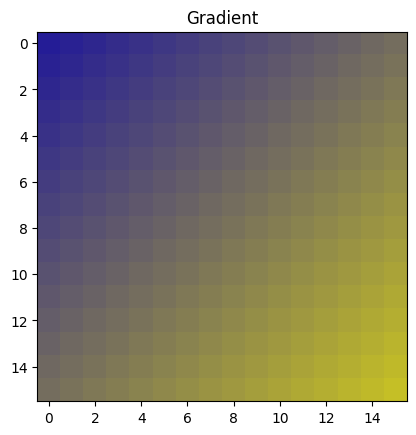

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5534406..2.9709845].


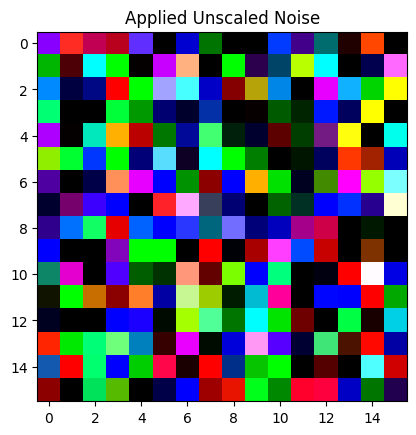

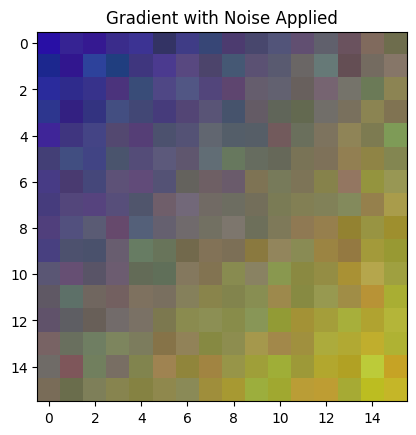

Batch element 1


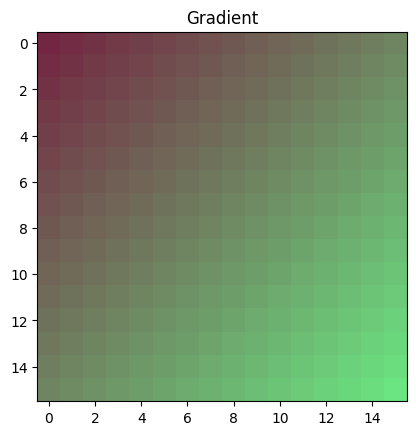

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1924314..3.4434137].


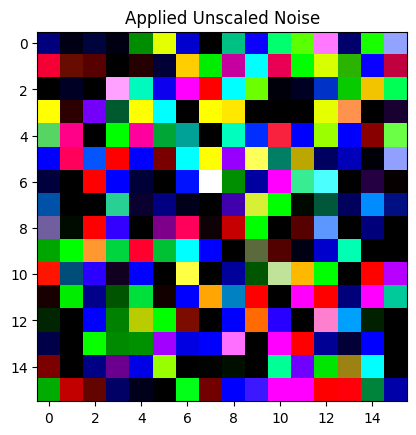

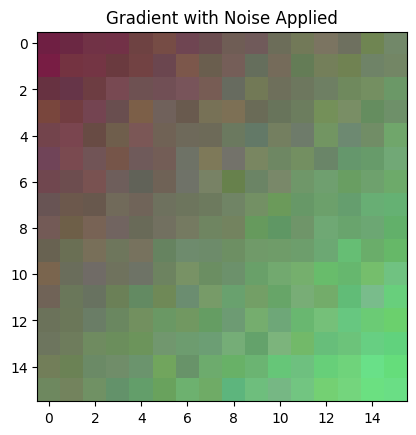

TypeError: mean() received an invalid combination of arguments - got (dims=tuple, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [15]:
noise_schedule = NoiseSchedule(max_steps=200, device="cpu")
img = gradient_images(2, (3, 16, 16))
(num_steps, noise, noised) = noise_img(normalize_img(img), noise_schedule, max_steps=10)
for i in range(img.shape[0]):
    print(f"Batch element {i}")
    plot_img(img[i], "Gradient")
    plot_img(noise[i], "Applied Unscaled Noise")
    plot_img(denormalize_img(noised[i]), "Gradient with Noise Applied")
toy_model_tests.test_noise_img(noise_img, NoiseSchedule, gradient_images, normalize_img)

In [16]:
t.mean??

Docstring:
mean(input, *, dtype=None) -> Tensor

Returns the mean value of all elements in the :attr:`input` tensor. Input must be floating point or complex.

Args:
    input (Tensor):
      the input tensor, either of floating point or complex dtype

Keyword args:
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        If specified, the input tensor is casted to :attr:`dtype` before the operation
        is performed. This is useful for preventing data type overflows. Default: None.

Example::

    >>> a = torch.randn(1, 3)
    >>> a
    tensor([[ 0.2294, -0.5481,  1.3288]])
    >>> torch.mean(a)
    tensor(0.3367)

.. function:: mean(input, dim, keepdim=False, *, dtype=None, out=None) -> Tensor
   :noindex:

Returns the mean value of each row of the :attr:`input` tensor in the given
dimension :attr:`dim`. If :attr:`dim` is a list of dimensions,
reduce over all of them.


If :attr:`keepdim` is ``True``, the output tensor is of the same size
as :at

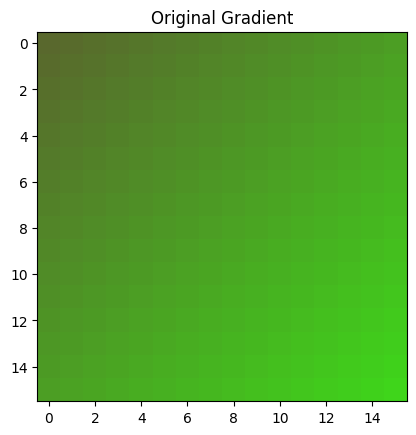

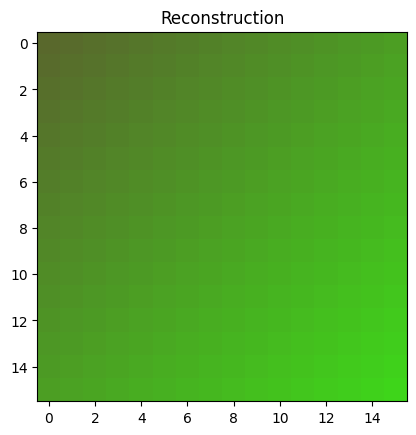

toy_model_tests.test_reconstruct passed in 0.00s.


In [ ]:
def reconstruct(
    noisy_img: t.Tensor,
    noise: t.Tensor,
    num_steps: t.Tensor,
    noise_schedule: NoiseSchedule,
) -> t.Tensor:
    """
    Subtract the scaled noise from noisy_img to recover the original image. We'll later use this with the model's output to log reconstructions during training. We'll use a different method to sample images once the model is trained.

    Returns img, a tensor with shape (B, C, H, W)
    """
    B, C, H, W = noisy_img.shape
    x_scale = noise_schedule.alpha_bar(num_steps).sqrt()
    noise_scale = (1 - noise_schedule.alpha_bar(num_steps)).sqrt()
    img = noisy_img - repeat(noise_scale, "b -> b c h w", c=C, h=H, w=W) * noise
    img = img / repeat(x_scale, "b -> b c h w", c=C, h=H, w=W)
    assert img.shape == (B, C, H, W)
    return img


reconstructed = reconstruct(noised, noise, num_steps, noise_schedule)
denorm = denormalize_img(reconstructed)
plot_img(img[0], "Original Gradient")
plot_img(denorm[0], "Reconstruction")
toy_model_tests.test_reconstruct(denorm, img)

In [ ]:
class DiffusionModel(nn.Module):
    img_shape: tuple[int, ...]
    noise_schedule: Optional[NoiseSchedule]


@dataclass(frozen=True)
class TinyDiffuserConfig:
    img_shape: tuple[int, ...]
    hidden_size: int
    max_steps: int


class TinyDiffuser(DiffusionModel):
    config: TinyDiffuserConfig
    img_shape: tuple[int, ...]
    noise_schedule: Optional[NoiseSchedule]
    max_steps: int
    model: nn.Sequential

    def __init__(self, config: TinyDiffuserConfig):
        """
        A toy diffusion model composed of an MLP (Linear, ReLU, Linear).
        """
        super().__init__()
        self.config = config
        self.img_shape = config.img_shape
        self.noise_schedule = None
        self.max_steps = config.max_steps
        
        assert len(config.img_shape) == 3
        num_pixels = int(reduce(mul, config.img_shape))
        self.model = nn.Sequential(
            nn.Linear(num_pixels + 1, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, num_pixels),
            Rearrange(
                "b (c h w) -> b c h w",
                c=config.img_shape[0],
                h=config.img_shape[1],
                w=config.img_shape[2],
            ),
        )

    def forward(self, images: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        """
        Given a batch of images and noise steps applied, attempt to predict the noise that was applied.
        images: tensor of shape (B, C, H, W)
        num_steps: tensor of shape (B,)

        Returns
        noise_pred: tensor of shape (B, C, H, W)
        """
        
        B, C, H, W = images.shape
        assert num_steps.shape == (B,)
        num_steps = num_steps / self.max_steps
        model_in = t.cat(
            (
                rearrange(num_steps, "(b 1) -> b 1"),
                rearrange(images, "b c h w -> b (c h w)"),
            ),
            dim=-1,
        )
        out = self.model(model_in)
        assert out.shape == (B, C, H, W)
        return out


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46188432..0.43444133].


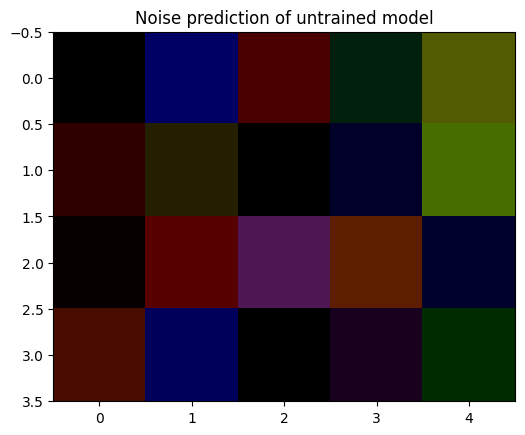

toy_model_tests.test_tiny_diffuser passed in 0.00s.


In [ ]:
img_shape = (3, 4, 5)
n_images = 5
imgs = gradient_images(n_images, img_shape)
n_steps = t.zeros(imgs.size(0))
model_config = TinyDiffuserConfig(img_shape, 16, 100)
model = TinyDiffuser(model_config)
out = model(imgs, n_steps)
plot_img(out[0].detach(), "Noise prediction of untrained model")
toy_model_tests.test_tiny_diffuser(TinyDiffuser, TinyDiffuserConfig)

In [ ]:
def log_images(
    img: t.Tensor,
    noised: t.Tensor,
    noise: t.Tensor,
    noise_pred: t.Tensor,
    reconstructed: t.Tensor,
    num_images: int = 3,
) -> list[wandb.Image]:
    """
    Convert tensors to a format suitable for logging to Weights and Biases. Returns an image with the ground truth in the upper row, and model reconstruction on the bottom row. Left is the noised image, middle is noise, and reconstructed image is in the rightmost column.
    """
    actual = t.cat((noised, noise, img), dim=-1)
    pred = t.cat((noised, noise_pred, reconstructed), dim=-1)
    log_img = t.cat((actual, pred), dim=-2)
    images = [wandb.Image(i) for i in log_img[:num_images]]
    return images


def train(
    model: DiffusionModel,
    config_dict: dict[str, Any],
    trainset: TensorDataset,
    testset: Optional[TensorDataset] = None,
) -> DiffusionModel:

    wandb.init(project="diffusion_models", config=config_dict, mode="disabled" if IS_CI else None)
    config = wandb.config
    print(f"Training with config: {config}")

    schedule = NoiseSchedule(config.max_steps, config.device)
    model.noise_schedule = schedule

    model.train()
    optimizer = t.optim.Adam(model.parameters(), lr=config.lr)

    train_loader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True)
    if testset is not None:
        test_loader = DataLoader(testset, batch_size=config.batch_size)

    start_time = time.time()
    examples_seen = 0
    for epoch in range(config.epochs):
        for i, (x,) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}")):
            x = x.to(config.device)
            num_steps, noise, noised = noise_img(x, schedule)
            y_hat = model(noised, num_steps)
            loss = F.mse_loss(y_hat, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            info: dict[str, Any] = dict(
                train_loss=loss,
                elapsed=time.time() - start_time,
                y_hat_mean=y_hat.mean(),
                y_hat_var=y_hat.var(),
                noised_mean=noised.mean(),
                noised_var=noised.var(),
            )
            if (i + 1) % config.img_log_interval == 0:
                reconstructed = reconstruct(noised, y_hat, num_steps, schedule)
                info["images"] = log_images(
                    img=x,
                    noised=noised,
                    noise=noise,
                    noise_pred=y_hat,
                    reconstructed=reconstructed,
                    num_images=config.n_images_to_log,
                )

            examples_seen += len(x)
            wandb.log(info, step=examples_seen)
        if testset is not None:
            losses = []
            for i, (x,) in enumerate(tqdm(test_loader, desc=f"Eval for Epoch {epoch + 1}")):
                x = x.to(config.device)
                num_steps, noise, noised = noise_img(x, schedule)
                with t.inference_mode():
                    y_hat = model(noised, num_steps)
                    loss = F.mse_loss(y_hat, noise)
                losses.append(loss.item())
            eval_info = dict(eval_loss=sum(losses) / len(losses))
            wandb.log(eval_info, step=examples_seen)

    wandb.finish()
    return model

In [ ]:
config: dict[str, Any] = dict(
    lr=1e-3,
    image_shape=(3, 4, 5),
    hidden_size=128,
    epochs=20 if not IS_CI else 1,
    max_steps=100,
    batch_size=128,
    img_log_interval=200,
    n_images_to_log=3,
    n_images=50000 if not IS_CI else 10,
    n_eval_images=1000 if not IS_CI else 10,
    device=t.device("cuda") if t.cuda.is_available() else t.device("cpu"),
)
images = normalize_img(
    gradient_images(
        config["n_images"],
        config["image_shape"],
    )
)
train_set = TensorDataset(images)
images = normalize_img(
    gradient_images(
        config["n_eval_images"],
        config["image_shape"],
    )
)
test_set = TensorDataset(images)

model_config = TinyDiffuserConfig(config["image_shape"], config["hidden_size"], config["max_steps"])
model = TinyDiffuser(model_config).to(config["device"])

model = train(model, config, train_set, test_set)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: michaelyliu6 (michaelyliu6-none). Use `wandb login --relogin` to force relogin


Training with config: {'lr': 0.001, 'image_shape': [3, 4, 5], 'hidden_size': 128, 'epochs': 20, 'max_steps': 100, 'batch_size': 128, 'img_log_interval': 200, 'n_images_to_log': 3, 'n_images': 50000, 'n_eval_images': 1000, 'device': 'cpu'}


Eval for Epoch 20: 100%|██████████| 8/8 [00:00<00:00, 2513.63it/s]


elapsed,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇█████
eval_loss,█▇▇▇▅▇▆▅▅▅▅▅▄▃▂▂▂▁▃▁
noised_mean,▃▅▃▆▄▃▃▃▅▃▇▅▃▃▄▁▅▅▃██▄▃▅▆▃▅▆▃▄▇▅▅▃▂▅▂▅▅▄
noised_var,▅▅▃▄▄▇▃▆▆▂▃▄▅▅▄█▅▅▄▁▂▃▁▂▃▇▄▃▃▅▃▄▅▂▅▅▅▂▃▄
train_loss,█▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
y_hat_mean,▄▃▃▃▃▄▆▄▄▅▄▄▁▃▄▆▄▂▁█▄▆▅▅▄▄▂▆▃▄▆▃▄▅▃▅▅▆▆▂
y_hat_var,▁▄▇▇▇▇▆▇▇▆▇█▇▇▇▇▆▇▇▇▇▇▆▇▇▇██████▇▇▇▇████
elapsed,5.26338
eval_loss,0.19108
noised_mean,-0.01086
noised_var,0.36617


In [ ]:
def sample(model: DiffusionModel, n_samples: int, return_all_steps: bool = False) -> Union[t.Tensor, list[t.Tensor]]:
    """
    Sample, following Algorithm 2 in the DDPM paper

    model: The trained noise-predictor
    n_samples: The number of samples to generate
    return_all_steps: if true, return a list of the reconstructed tensors generated at each step, rather than just the final reconstructed image tensor.

    out: shape (B, C, H, W), the denoised images
    """
    schedule = model.noise_schedule
    assert schedule is not None
    
    model.eval()
    if return_all_steps:
        all_steps: list[t.Tensor] = []
    shape = (n_samples, *model.img_shape)
    B, C, H, W = shape
    x = t.randn(shape, device=schedule.device)
    if return_all_steps:
        all_steps.append(x.cpu().clone())
    for step in tqdm(reversed(range(0, len(schedule))), total=len(schedule)):
        num_steps = t.full((n_samples,), fill_value=step, device=schedule.device)

        if step > 0:
            # if you remove the sqrt in the following line, it makes better gradients. Why???
            sigma = schedule.beta(step)
            # sigma = schedule.beta(step).sqrt()
            noise_term = sigma * t.randn_like(x)
        else:
            noise_term = 0

        pred = model(x, num_steps)

        pred_scale = schedule.beta(step) / ((1 - schedule.alpha_bar(step)).sqrt())
        denoised_scale = 1 / schedule.alpha(step).sqrt()
        x = denoised_scale * (x - pred_scale * pred) + noise_term

        if return_all_steps:
            all_steps.append(x.cpu().clone())
    if return_all_steps:
        return all_steps
    return x

Generating multiple images


100%|██████████| 100/100 [00:00<00:00, 15678.47it/s]


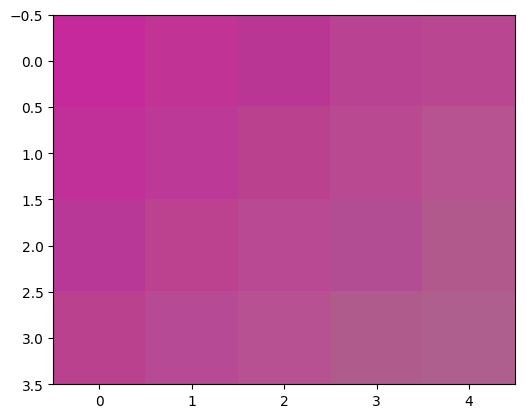

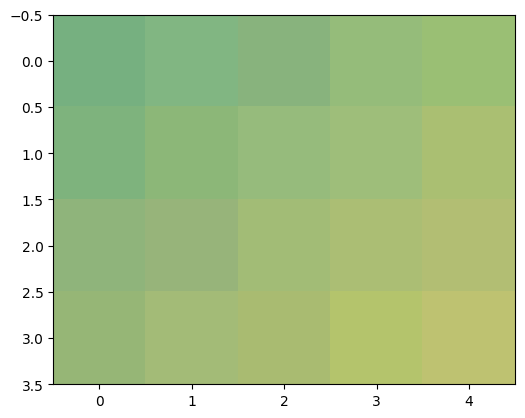

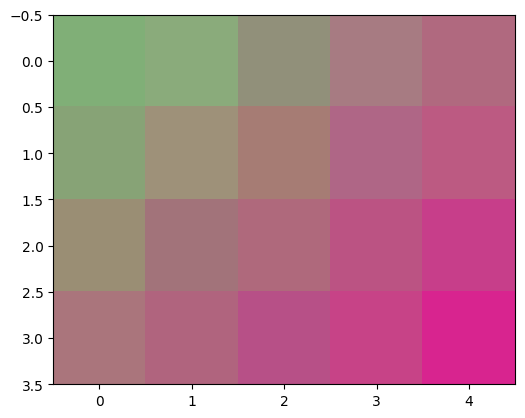

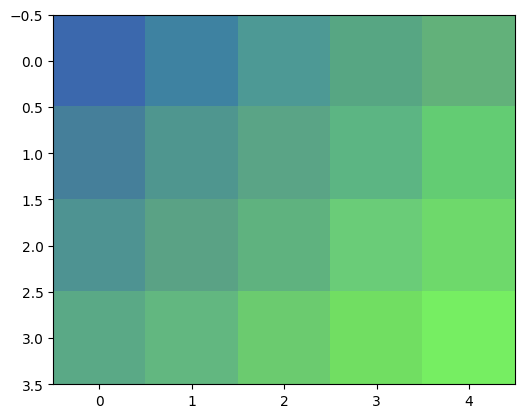

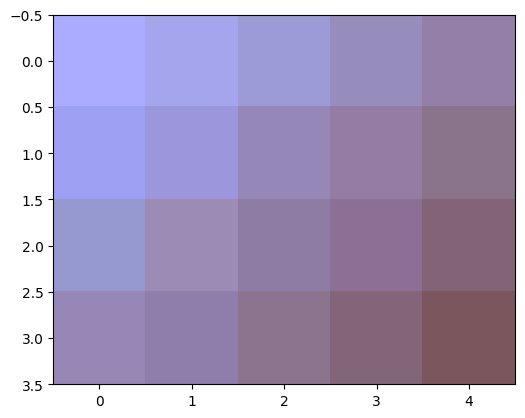

In [ ]:
print("Generating multiple images")
assert isinstance(model, DiffusionModel)
with t.inference_mode():
    samples = sample(model, 5)
for s in samples:
    plot_img(denormalize_img(s).cpu())

Printing sequential denoising


100%|██████████| 100/100 [00:00<00:00, 15186.30it/s]


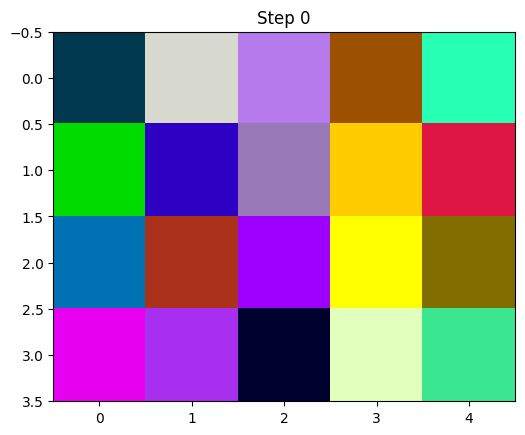

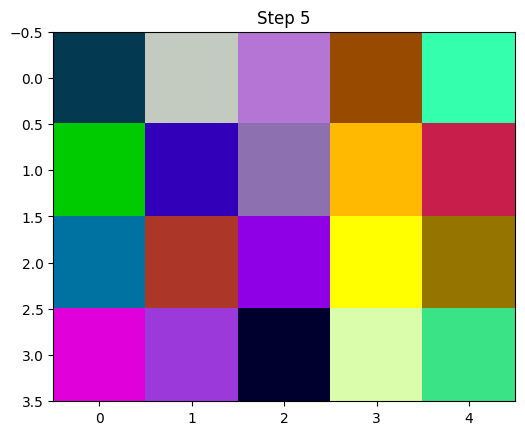

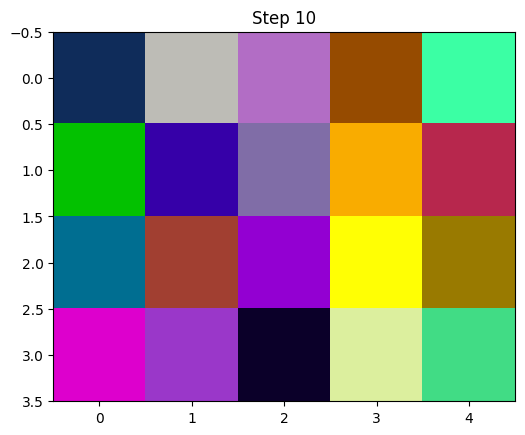

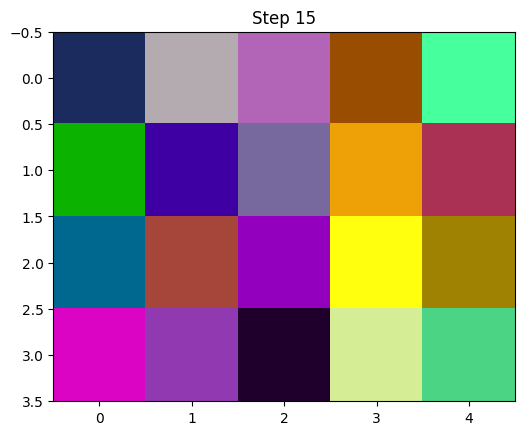

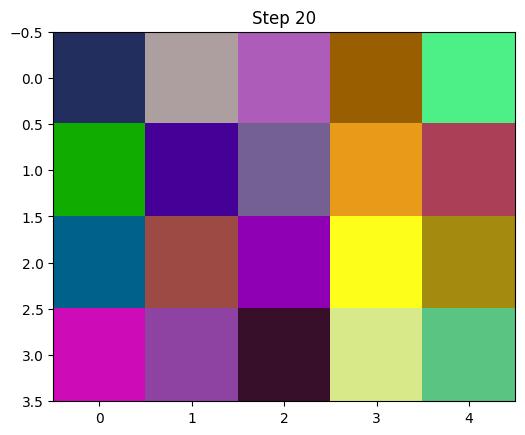

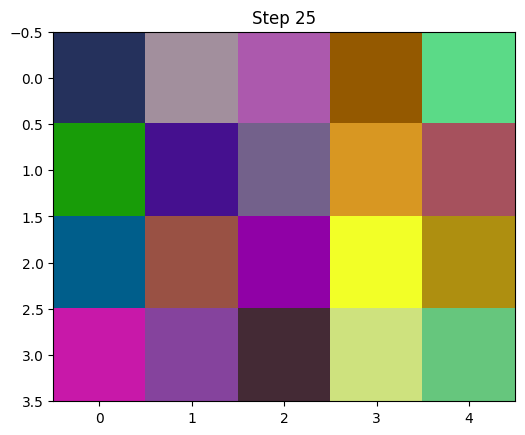

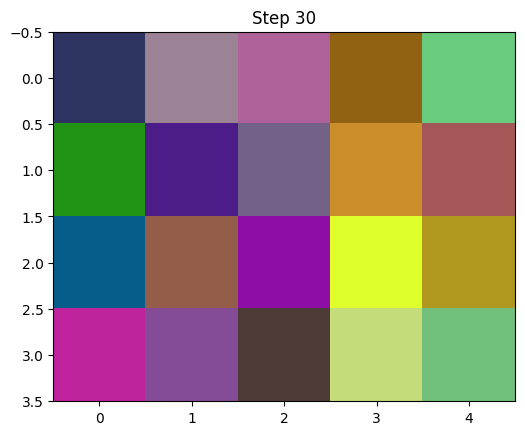

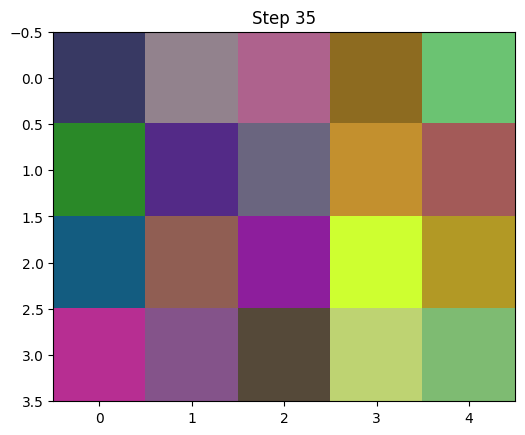

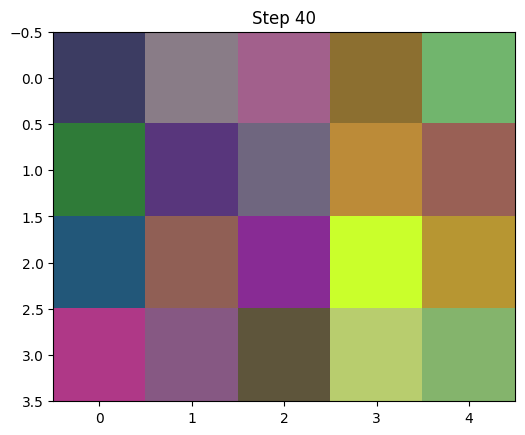

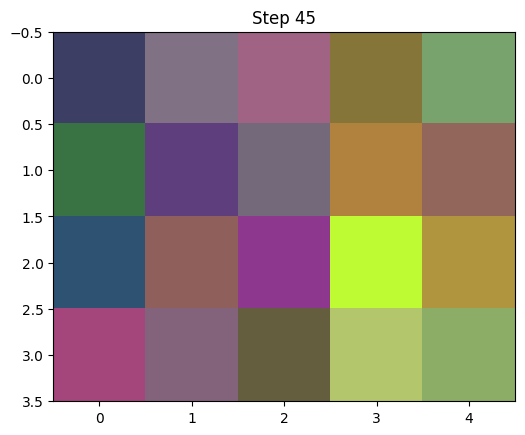

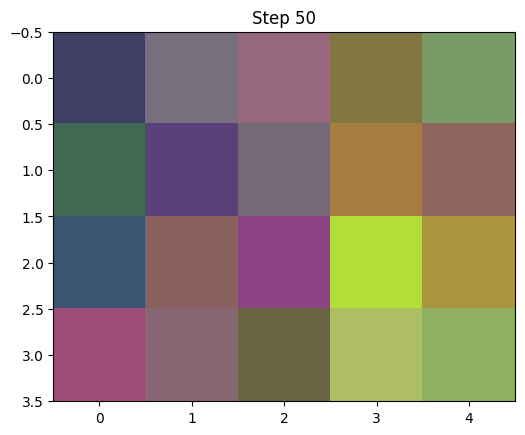

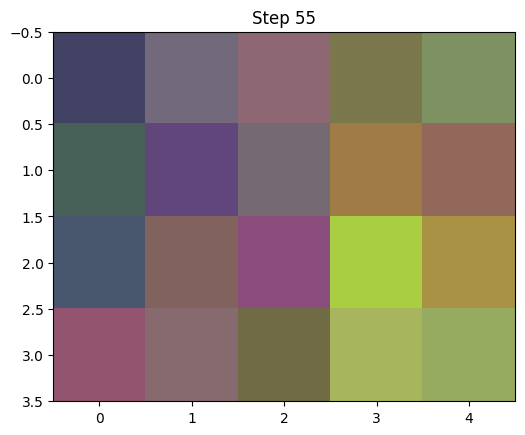

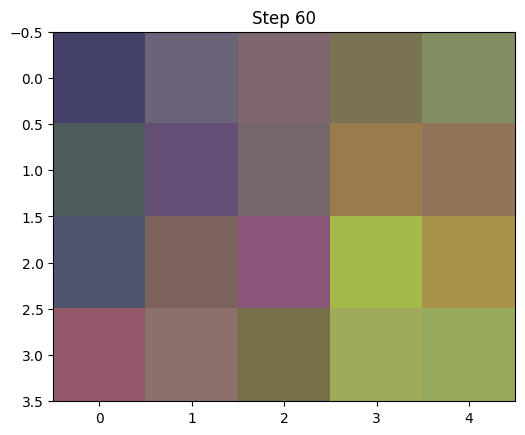

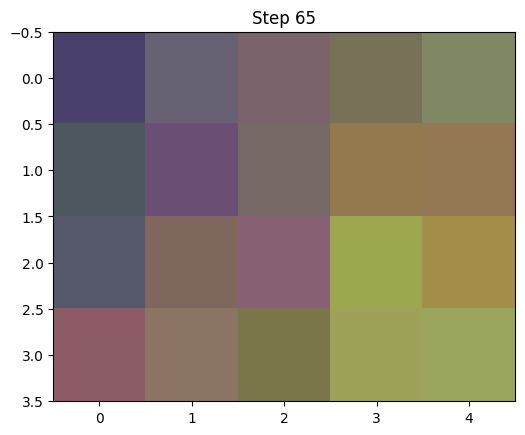

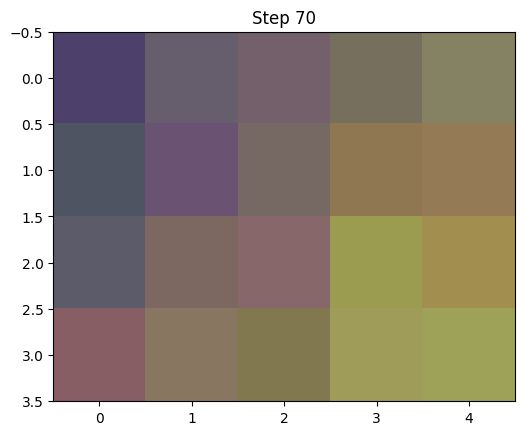

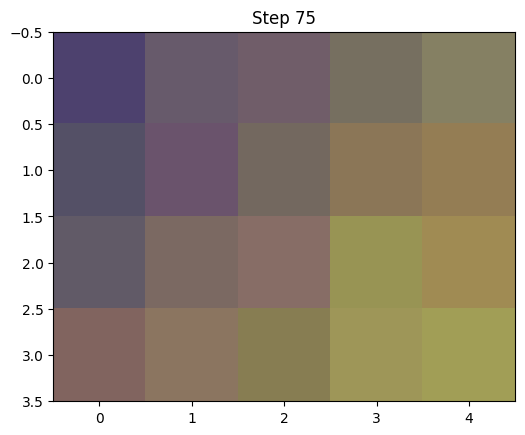

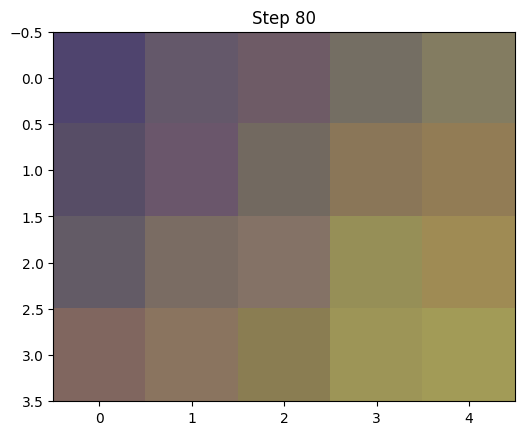

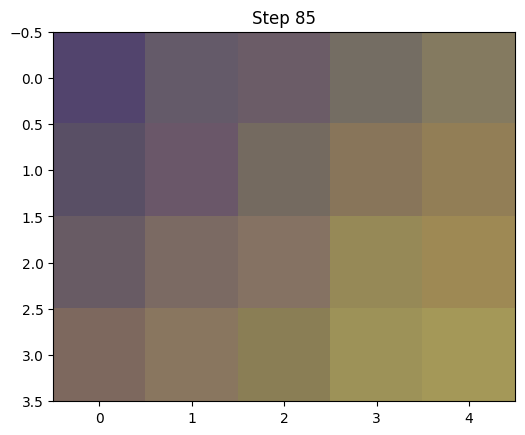

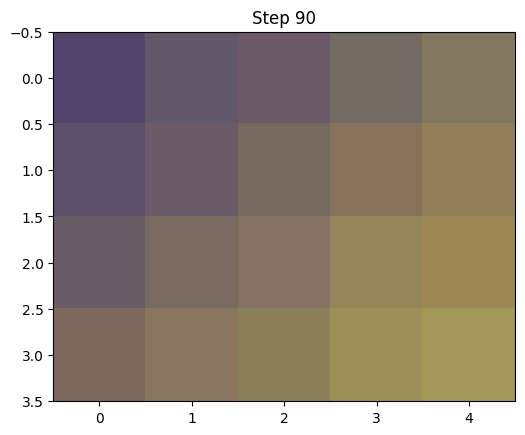

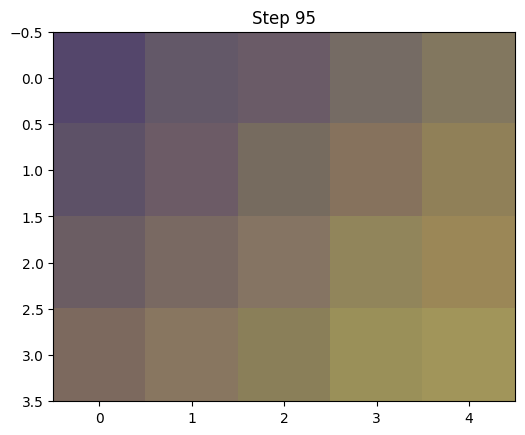

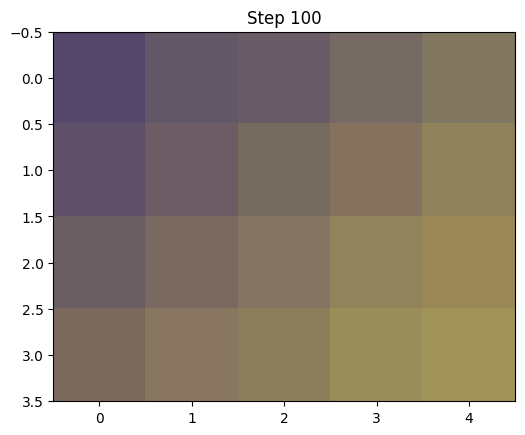

In [ ]:
print("Printing sequential denoising")
assert isinstance(model, DiffusionModel)
with t.inference_mode():
    samples = sample(model, 1, return_all_steps=True)
for i, s in enumerate(samples):
    if i % (len(samples) // 20) == 0:
        plot_img(denormalize_img(s[0]), f"Step {i}")